# Diffusive Instability
## Introduction and Smoketests

This notebook
- load the page config
- runs the unit tests
- does an EVP sweep for stable and unstable baselines and plots growth vs k
- shows how to read written artifcacts (manifest, checpoints)

Goal is to make this into tutorial notebook

In [21]:
import json
import numpy as np
import matplotlib.pyplot as plt

checks if diffinst is installed from repo root, and installs it otherwise (`pip install -e`)

In [22]:
# %% Project bootstrap (root, imports, editable install)
from pathlib import Path
import sys, os, subprocess, importlib.util

def find_project_root(start: Path) -> Path:
    """Walk up until we see a project marker (pyproject.toml, .git, or defaults.yaml)."""
    p = start.resolve()
    markers = {"pyproject.toml", ".git", "defaults.yaml"}
    while p != p.parent:
        if any((p / m).exists() for m in markers):
            return p
        p = p.parent
    return start.resolve()

# works for both .ipynb (no __file__) and .py notebooks
_here = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
ROOT = find_project_root(_here)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

def ensure_editable_installed(pkg_name: str, pkg_dir: Path):
    """Install `-e .` iff the import isn't present or doesn't point to this repo."""
    spec = importlib.util.find_spec(pkg_name)
    if not spec or not getattr(spec, "origin", None):
        need_install = True
    else:
        # e.g. .../diffinst/__init__.py  → compare parent (package dir) to repo path
        pkg_path = Path(spec.origin).resolve().parent
        need_install = not pkg_path.samefile(pkg_dir.resolve())
    if need_install:
        print(f"Installing {pkg_name} in editable mode from {ROOT} ...")
        subprocess.run([sys.executable, "-m", "pip", "install", "-e", str(ROOT)], check=True)
    else:
        print(f"{pkg_name} already installed from this repo.")

ensure_editable_installed("diffinst", ROOT / "diffinst")

# now imports are safe and point to this repo
from diffinst import Config
from diffinst.linear_ops import evp_solve_at_k

# handy paths
EXP_STABLE   = ROOT / "experiments" / "baseline.yaml"
EXP_UNSTABLE = ROOT / "experiments" / "unstable_baseline.yaml"
EXP_LARGEDIFF = ROOT / "experiments" / "diffinst_largeDiff_limit.yaml"
DEFAULTS     = ROOT / "defaults.yaml"
RUNS         = ROOT / "runs"; RUNS.mkdir(exist_ok=True)

print("project root:", ROOT)

diffinst already installed from this repo.
project root: /Users/konstantingerbig/Documents/Science/ScienceProjects/diff-inst


## Tests

Currently:
- test_config.py
- test_evp.py
- test_io.py

NOTE: tests also don't really work. need to update this.

In [23]:
import pytest
res = pytest.main(["-q"])
print("pytest exit code:", res)

....F                                                                    [100%]
=================================== FAILURES ===================================
___________________ test_nonlinear_pure_diffusion_mode_decay ___________________

tmp_path = PosixPath('/private/var/folders/3s/5s9g_f892kq7kgfwgjspwqlc0000gn/T/pytest-of-konstantingerbig/pytest-0/test_nonlinear_pure_diffusion_0')

    def test_nonlinear_pure_diffusion_mode_decay(tmp_path: Path):
        base = Config.from_yaml("experiments/baseline.yaml", "defaults.yaml")
    
        # Create a modified copy (frozen dataclass -> use replace).
        # Only pass fields that exist in Config.__init__.
        cfg = replace(
            base,
            Nx=256,
            Lx=2.0 * np.pi,
            Omega=0.0,   # no Coriolis/shear (shear coupling vanishes with Omega=0)
            D_0=1e-3,    # constant diffusion
            nu_0=0.0,    # no viscosity
        )
    
        outdir = tmp_path / "nl"
        outdir.mkdir(pare

## EVP sweep with unstable baseline

Compute dominant eigenvalue for each k and plot growth (= Re(n))

In [24]:
cfg = Config.from_yaml(EXP_UNSTABLE, DEFAULTS)
kmin, kmax, nk = 10, 1e4, 120
ks = np.logspace(np.log10(kmin), np.log10(kmax), nk)

growth = np.empty(nk)
freq   = np.empty(nk)
for i, k in enumerate(ks):
    w, _ = evp_solve_at_k(cfg, float(k))
    growth[i] = w[0].real
    freq[i]   = w[0].imag

imax = int(np.argmax(growth))
print(f"max growth at k ≈ {ks[imax]:.3g}  ->  γ ≈ {growth[imax]:.4g},  ω ≈ {freq[imax]:.4g}")

max growth at k ≈ 411  ->  γ ≈ 0.4155,  ω ≈ 1.08e-16


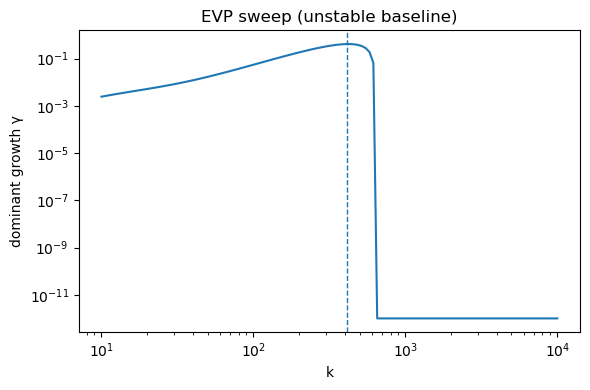

In [25]:
plt.figure(figsize=(6,4))
plt.loglog(ks, np.maximum(growth, 1e-12))  # show tiny values as floor
plt.axvline(ks[imax], ls="--", lw=1)
plt.xlabel("k")
plt.ylabel("dominant growth γ")
plt.title("EVP sweep (unstable baseline)")
#plt.title(r"EVP sweep $\delta = 10^5$")
plt.tight_layout()

## Eigenvector

S = sig/sig_0

In [26]:
from numpy import angle
w, V = evp_solve_at_k(cfg, float(ks[imax]))
dom_v = V[:,0]  # [S, vx, vy, uy]
labels = ["S", "vx", "vy", "uy"]
amps = np.abs(dom_v)
phs  = angle(dom_v)

for lab, a, p in zip(labels, amps, phs):
    print(f"{lab:>2s}: |.|={a:.3e},  phase={p:.3f} rad")

 S: |.|=1.000e+00,  phase=0.000 rad
vx: |.|=1.012e-03,  phase=-1.571 rad
vy: |.|=7.566e-04,  phase=-1.571 rad
uy: |.|=4.226e-05,  phase=-1.571 rad


## Read a manifest / checkpoint from a dry run

Run
`python -m scripts.run_linear --config experiments/baseline.yaml --outdir runs/linear --dry-run`
from notebook via bang command CLI. 

In [22]:
!python -m scripts.run_linear --config experiments/baseline.yaml --outdir runs/linear --dry-run

[dry] wrote one checkpoint; backend = native | Lx = 0.12566370614359174


load manifests and checkpoints of dryrun

In [23]:
run_dir = ROOT / "runs" / "linear"
man = run_dir / "run.json"
chk0 = run_dir / "checkpoints" / "chk_000000.npz"

if man.exists() and chk0.exists():
    with man.open() as f:
        meta = json.load(f)
    arrs = np.load(chk0)
    print("manifest keys:", list(meta.keys()))
    print("checkpoint arrays:", arrs.files)
    for key in arrs.files:
        print(f"  {key}: shape={arrs[key].shape}, dtype={arrs[key].dtype}")
else:
    print("no dry-run outputs found; run the dry script once to populate.")

manifest keys: ['kind', 'config', 'Nx', 'Lx', 'backend']
checkpoint arrays: ['t', 'sigma', 'vx', 'vy', 'uy']
  t: shape=(), dtype=float64
  sigma: shape=(128,), dtype=float64
  vx: shape=(128,), dtype=float64
  vy: shape=(128,), dtype=float64
  uy: shape=(128,), dtype=float64


In [24]:
!python -m scripts.run_evp --config experiments/unstable_baseline.yaml --kmin 10 --kmax 1e3 --nk 120 --out runs/evp_unstable --plot

[evp] max growth at k=426.8: gamma=0.4163, omega=-1.297e-16
[evp] saved plot -> runs/evp_unstable/preview_growth.png


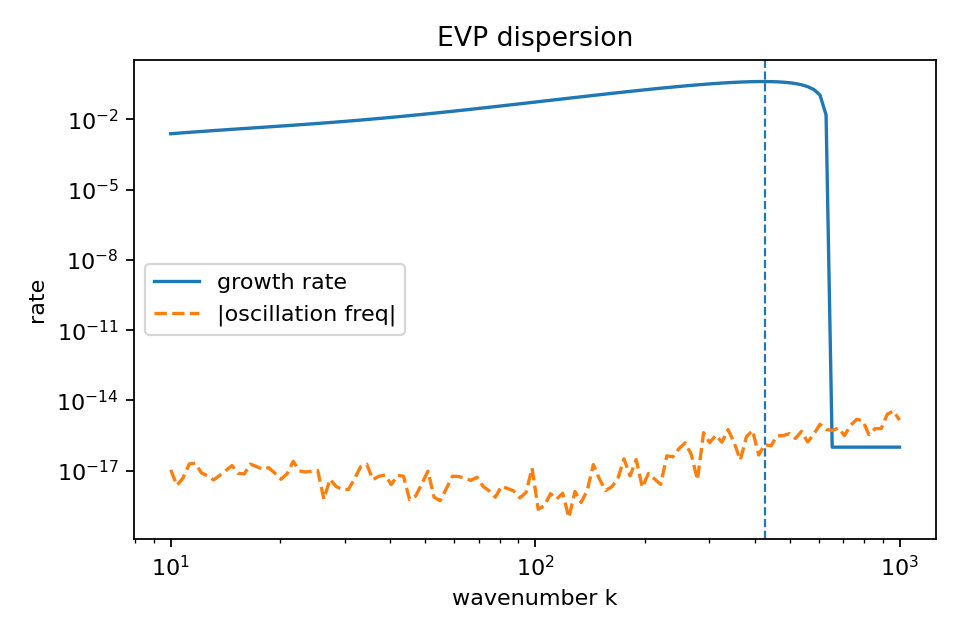

In [25]:
from IPython.display import Image, display
display(Image(filename="runs/evp_unstable/preview_growth.png"))